<a href="https://colab.research.google.com/github/hemil19/Detecting-Anomalies-in-Wafer-Manufacturing/blob/master/Anomalies_in_wafer_manufacturing_Machine_Hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('/content/Train.csv')
test=pd.read_csv('/content/Test.csv')

In [3]:
train.shape,test.shape

((1763, 1559), (756, 1558))

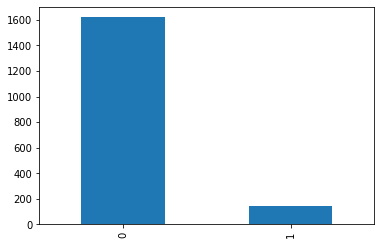

In [4]:
train['Class'].value_counts().plot(kind='bar')

In [5]:
train.isnull().sum()

feature_1       0
feature_2       0
feature_3       0
feature_4       0
feature_5       0
               ..
feature_1555    0
feature_1556    0
feature_1557    0
feature_1558    0
Class           0
Length: 1559, dtype: int64

In [6]:
test.isnull().sum()

feature_1       0
feature_2       0
feature_3       0
feature_4       0
feature_5       0
               ..
feature_1554    0
feature_1555    0
feature_1556    0
feature_1557    0
feature_1558    0
Length: 1558, dtype: int64

In [7]:
train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,...,feature_1520,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
X=train.drop('Class',axis=1)
y=train['Class']

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 30 best features
bestfeatures = SelectKBest(score_func=chi2, k=30)
fit = bestfeatures.fit(X,y)

In [10]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

In [11]:
featureScores.nlargest(102,'Score')

,Specs,Score
1,feature_2,25673.484371
1399,feature_1400,302.309788
1243,feature_1244,259.177842
1153,feature_1154,230.140289
1047,feature_1048,226.563474
...,...,...
356,feature_357,23.542357
734,feature_735,23.542357
1338,feature_1339,23.542357
36,feature_37,22.579027


In [12]:
X=X[featureScores.nlargest(102,'Score')['Specs']]
test=test[X.columns]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(n_estimator=5000,
                       random_state=1994,
                       learning_rate=0.05,
                       reg_alpha=0.2,
                       colsample_bytree=0.5,
                       bagging_fraction=0.9)

model.fit(X_train,y_train,
          eval_set=[(X_train,y_train),(X_test, y_test)],
          eval_metric='auc',
          early_stopping_rounds=100,
          verbose=200)

pred_y = model.predict_proba(X_test)[:,1]
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
print(roc_auc_score(y_test, pred_y))
confusion_matrix(y_test, pred_y>0.5)

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.11913	training's auc: 0.966404	valid_1's binary_logloss: 0.195569	valid_1's auc: 0.906432
0.9064315768383089


array([[310,  12],
       [ 22,   9]])

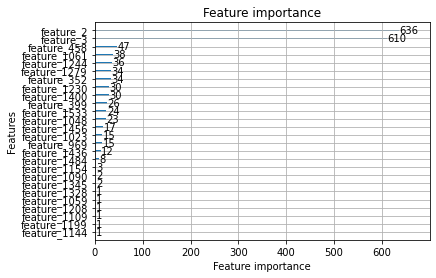

In [15]:
import lightgbm
lightgbm.plot_importance(model)

In [16]:
err = []
y_pred_tot_lgm = []

from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1994)
i = 1
for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = LGBMClassifier(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.08,
                       n_estimators=5000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       random_state=1994)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          eval_metric='auc',
          verbose=200)
    pred_y = m.predict_proba(x_val)[:,1]
    print("err_lgm: ",roc_auc_score(y_val,pred_y))
    err.append(roc_auc_score(y_val, pred_y))
    pred_test = m.predict_proba(test)[:,1]
    i = i + 1
    y_pred_tot_lgm.append(pred_test)

Training until validation scores don't improve for 200 rounds.
[200]	training's binary_logloss: 0.108364	training's auc: 0.972964	valid_1's binary_logloss: 0.153975	valid_1's auc: 0.945885
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.143659	training's auc: 0.950548	valid_1's binary_logloss: 0.144983	valid_1's auc: 0.954115
err_lgm:  0.9541152263374485
Training until validation scores don't improve for 200 rounds.
[200]	training's binary_logloss: 0.11002	training's auc: 0.972147	valid_1's binary_logloss: 0.187589	valid_1's auc: 0.928189
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.1421	training's auc: 0.95335	valid_1's binary_logloss: 0.185278	valid_1's auc: 0.925309
err_lgm:  0.9253086419753086
Training until validation scores don't improve for 200 rounds.
[200]	training's binary_logloss: 0.109504	training's auc: 0.972683	valid_1's binary_logloss: 0.166849	valid_1's auc: 0.942387
Early stopping, best iteration is:
[117]	training's binary_

In [17]:
np.mean(err,0)

0.9143371546149325

In [18]:
from xgboost import XGBClassifier

errxgb = []
y_pred_tot_xgb = []

from sklearn.model_selection import KFold,StratifiedKFold

fold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1994)
i = 1
for train_index, test_index in fold.split(X,y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = XGBClassifier(boosting_type='gbdt',
                      max_depth=5,
                      learning_rate=0.07,
                      n_estimators=5000,
                      random_state=1994)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          eval_metric='auc',
          verbose=200)
    pred_y = m.predict_proba(x_val)[:,-1]
    print("err_xgb: ",roc_auc_score(y_val,pred_y))
    errxgb.append(roc_auc_score(y_val, pred_y))
    pred_test = m.predict_proba(test)[:,-1]
    i = i + 1
    y_pred_tot_xgb.append(pred_test)

[0]	validation_0-auc:0.893626	validation_1-auc:0.9
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:0.977286	validation_1-auc:0.933128
Stopping. Best iteration:
[49]	validation_0-auc:0.956453	validation_1-auc:0.941564

err_xgb:  0.9415637860082305
[0]	validation_0-auc:0.90524	validation_1-auc:0.883128
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:0.974358	validation_1-auc:0.930041
Stopping. Best iteration:
[73]	validation_0-auc:0.963566	validation_1-auc:0.936214

err_xgb:  0.9362139917695473
[0]	validation_0-auc:0.89918	validation_1-auc:0.845679
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:

In [19]:
!pip install catboost

     |████████████████████████████████| 66.1MB 56kB/s 


In [20]:
from catboost import CatBoostClassifier,Pool, cv
errCB = []
y_pred_tot_cb = []
from sklearn.model_selection import KFold,StratifiedKFold

fold = StratifiedKFold(n_splits=15,shuffle=True,random_state=1994)
i = 1
for train_index, test_index in fold.split(X,y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    m = CatBoostClassifier(n_estimators=5000,
                           random_state=1994,
                           eval_metric='AUC',
                           learning_rate=0.03)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          verbose=200)
    pred_y = m.predict_proba(x_val)[:,-1]
    print("err_cb: ",roc_auc_score(y_val,pred_y))
    errCB.append(roc_auc_score(y_val,pred_y))
    pred_test = m.predict_proba(test)[:,-1]
    i = i + 1
    y_pred_tot_cb.append(pred_test)

0:	test: 0.6972864	test1: 0.7430556	best: 0.7430556 (0)	total: 54ms	remaining: 4m 29s
200:	test: 0.9409784	test1: 0.9180556	best: 0.9486111 (4)	total: 991ms	remaining: 23.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9486111111
bestIteration = 4

Shrink model to first 5 iterations.
err_cb:  0.9486111111111111
0:	test: 0.6759458	test1: 0.6916667	best: 0.6916667 (0)	total: 4.83ms	remaining: 24.1s
200:	test: 0.9382434	test1: 0.9574074	best: 0.9620370 (31)	total: 903ms	remaining: 21.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.962037037
bestIteration = 31

Shrink model to first 32 iterations.
err_cb:  0.9620370370370371
0:	test: 0.6774277	test1: 0.6675926	best: 0.6675926 (0)	total: 5.36ms	remaining: 26.8s
200:	test: 0.9469383	test1: 0.9101852	best: 0.9111111 (182)	total: 927ms	remaining: 22.1s
400:	test: 0.9639376	test1: 0.9166667	best: 0.9185185 (272)	total: 1.84s	remaining: 21.2s
Stopped by overfitting detector  (200 iterations wait)



In [21]:
(np.mean(errxgb, 0) + np.mean(err, 0) + np.mean(errCB, 0))/3

0.9177113136063753

In [22]:
submission=pd.DataFrame()
submission['Class']=(np.mean(y_pred_tot_lgm, 0) + np.mean(y_pred_tot_cb, 0) +np.mean(y_pred_tot_xgb, 0))/3

In [23]:
submission.head()

,Class
0,0.325021
1,0.067508
2,0.069913
3,0.361372
4,0.583290


In [24]:
submission.to_csv('ensemble_result.csv', index=False, header=True)
submission.shape

(756, 1)